#### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [3]:
## Establishing connection with MySQL Database

db = mysql.connector.connect(host='localhost',
                             username = 'root',
                             password='root',
                             database='sales_db')

cur = db.cursor()

#### Basic Queries

In [5]:
### List all unique cities where customers are located.
q1 = """SELECT DISTINCT customer_city FROM customers"""
cur.execute(q1)

data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [7]:
## Count the number of orders placed in 2017
q2 = """SELECT COUNT(*) FROM orders WHERE YEAR(order_purchase_timestamp)=2017"""

cur.execute(q2)
d2 = cur.fetchall()
d2

[(45101,)]

In [11]:
## Find the total sales per category
q3 = """ 
SELECT p.product_category,round(SUM(payment_value),2) AS total_sales
FROM payments s
LEFT JOIN order_item o on o.order_id = s.order_id
JOIN products p on p.product_id = o.product_id
GROUP BY p.product_category
ORDER BY 2 DESC
"""

cur.execute(q3)
d3 = cur.fetchall()
d3 

df = pd.DataFrame(d3,columns=['Category','Sales'])
df

,Category,Sales
0,bed table bath,1712553.67
1,HEALTH BEAUTY,1657373.12
2,computer accessories,1585330.45
3,Furniture Decoration,1430176.39
4,Watches present,1429216.68
...,...,...
69,PC Gamer,2174.43
70,House Comfort 2,1710.54
71,cds music dvds,1199.43
72,Fashion Children's Clothing,785.67


In [14]:
## Calculate the percentage of orders that were paid in installments
q4 = """
SELECT (SUM(CASE WHEN payment_installments>=1 THEN 1 END)/COUNT(*))*100
FROM payments
"""

cur.execute(q4)
d4 = cur.fetchall()
d4 

[(Decimal('99.9981'),)]

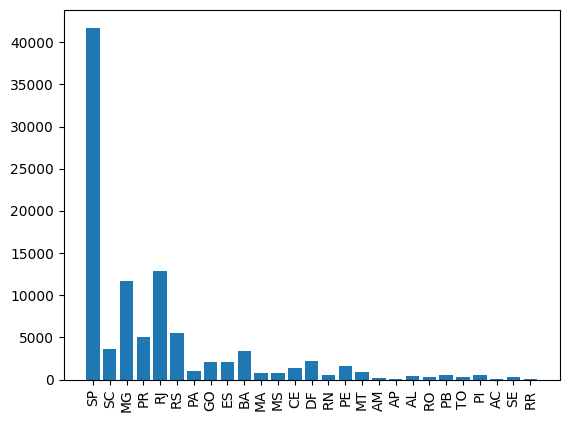

In [21]:
## Count the number of customers from each state
q5 = """ 
SELECT customer_state,count(customer_id)
FROM customers
GROUP BY customer_state
"""

cur.execute(q5)
d5 = cur.fetchall()

df = pd.DataFrame(d5,columns=['Customer_state','Customer_count'])
df.sort_values(by='Customer_count',ascending=False)
plt.bar(df['Customer_state'],df['Customer_count'])
plt.xticks(rotation = 90)
plt.show()

#### Intermediate Queries

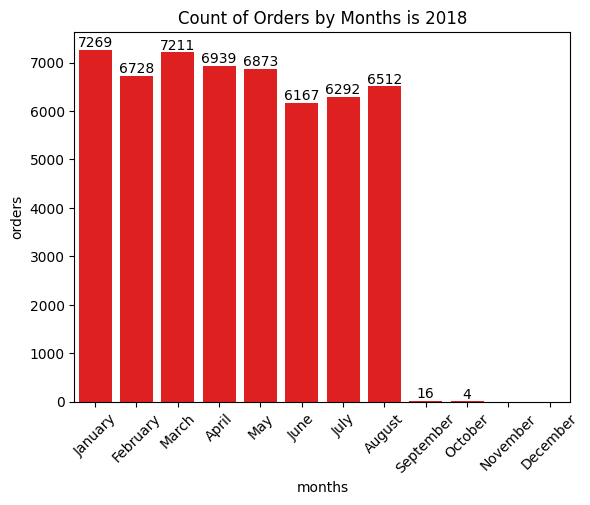

In [25]:
## Calculate the number of orders per month in 2018
q6 = """ 
SELECT MONTHNAME(order_purchase_timestamp),COUNT(order_id)
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTHNAME(order_purchase_timestamp)
"""

cur.execute(q6)
d6 = cur.fetchall()

df = pd.DataFrame(d6,columns=['months','orders'])
o = ["January", "February","March","April","May","June","July","August","September","October","November","December"]

ax = sns.barplot(x = df["months"],y =  df["orders"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [28]:
## Find the average number of products per order, grouped by customer city
q7 = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_item.order_id) as oc
from orders join order_item
on orders.order_id = order_item.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(q7)
d7 = cur.fetchall()
df = pd.DataFrame(d7,columns=['city','avg_order'])
df

,city,avg_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sebastiao leal,1.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


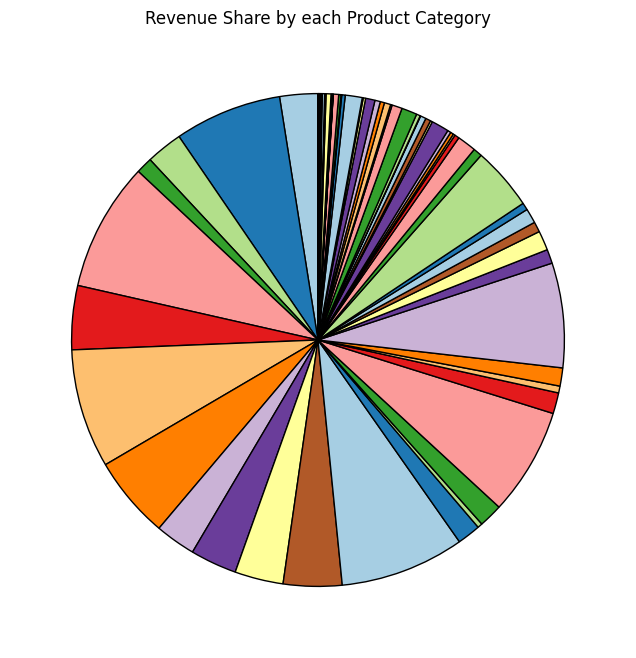

In [35]:
## Calculate the percentage of total revenue contributed by each product category
q8 = """ 
SELECT p.product_category as cat,round(SUM(payment_value)*100/(SELECT SUM(payment_value) FROM payments),2) AS total_sales
FROM payments s
LEFT JOIN order_item o on o.order_id = s.order_id
JOIN products p on p.product_id = o.product_id
GROUP BY p.product_category
"""

cur.execute(q8)
d8 = cur.fetchall()

df = pd.DataFrame(d8,columns=['category','percentage_revenue'])
plt.figure(figsize=(8,8))
plt.pie(
    df['percentage_revenue'],
    startangle=90,  # Start angle for better visual alignment
    colors=plt.cm.Paired.colors,  # Use a colormap for distinct colors
    wedgeprops={'edgecolor': 'black'}  # Add border for better visibility
)
plt.title("Revenue Share by each Product Category")
plt.show()

In [37]:
## Identify the correlation between product price and the number of times a product has been purchased
q9 = """ 
select products.product_category, 
count(order_item.product_id),
round(avg(order_item.price),2)
from products join order_item
on products.product_id = order_item.product_id
group by products.product_category
"""
cur.execute(q9)
d9 = cur.fetchall()
df = pd.DataFrame(d9,columns=['category','order_count','price'])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


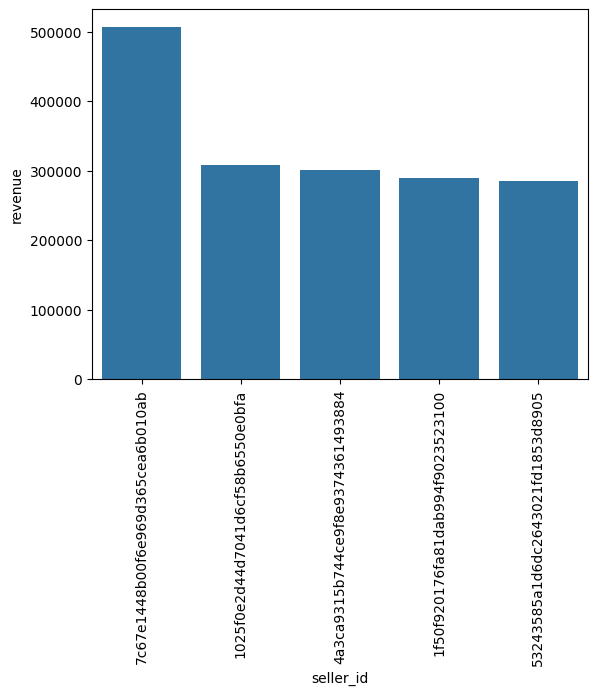

In [39]:
## Calculate the total revenue generated by each seller, and rank them by revenue
q10 = """ 
SELECT *,DENSE_RANK() OVER(ORDER BY revenue DESC) AS rvn
FROM
(SELECT o.seller_id,ROUND(SUM(p.payment_value),2) AS revenue
FROM order_item o 
JOIN payments p ON o.order_id = p.order_id
GROUP BY o.seller_id) as a
"""

cur.execute(q10)
d10 = cur.fetchall()
df = pd.DataFrame(d10,columns=['seller_id','revenue','ranking'])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

#### Advance Queries

In [40]:
## Calculate the moving average of order values for each customer over their order history
q11 = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(q11)
d11 = cur.fetchall()

df = pd.DataFrame(d11,columns=['customer','order_time','price','moving_avg'])
df.head()

,customer,order_time,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


In [41]:
## Calculate the cumulative sales per month for each year
q12 = """ 
SELECT year,month,payment AS sales,
ROUND(SUM(payment) OVER(ORDER BY year,month),2) AS cummulative_sales
FROM
(SELECT YEAR(order_purchase_timestamp) AS year,
MONTH(order_purchase_timestamp) AS month,
ROUND(SUM(payment_value),2) AS payment
FROM orders o
JOIN payments p on o.order_id = p.order_id
GROUP BY 1,2
ORDER BY 1,2) AS temp
"""

cur.execute(q12)
d12 = cur.fetchall()

df = pd.DataFrame(d12,columns=['year','month','sales','cummulative_sales'])

df

,year,month,sales,cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


In [42]:
## Calculate the year-over-year growth rate of total sales
q13 = """ 
WITH year_sales AS
(SELECT YEAR(o.order_purchase_timestamp) AS year,
ROUND(SUM(p.payment_value),2) AS sales
FROM orders o 
JOIN payments p ON o.order_id=p.order_id
GROUP BY year
ORDER BY year)

SELECT year,sales,
ROUND((sales- LAG(sales,1) OVER(ORDER BY YEAR))*100/LAG(sales,1) OVER(ORDER BY YEAR),2) AS yoy_growth_pct
FROM year_sales
"""

cur.execute(q13)
d13 = cur.fetchall()

df = pd.DataFrame(d13,columns=['year','sales',"yoy % growth"])
df

,year,sales,yoy % growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


In [43]:
## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase
q14 = """ 
WITH 
first_purchase AS
(SELECT c.customer_id AS customer_id,
MIN(o.order_purchase_timestamp) AS first_order
FROM
customers c
JOIN orders o ON c.customer_id = o.customer_id
GROUP BY c.customer_id),

next_purchase AS
(SELECT fp.customer_id,
COUNT( DISTINCT o.order_purchase_timestamp) AS next_order
FROM first_purchase fp
JOIN orders o ON fp.customer_id = o.customer_id AND
o.order_purchase_timestamp > fp.first_order AND
o.order_purchase_timestamp < DATE_ADD(fp.first_order,INTERVAL 6 MONTH)
GROUP BY fp.customer_id)

SELECT 100*(COUNT(DISTINCT a.customer_id)/COUNT(DISTINCT b.customer_id)) AS retention
FROM first_purchase AS a
LEFT JOIN next_purchase AS b ON a.customer_id = b.customer_id
"""

cur.execute(q14)

d14 = cur.fetchall()

df = pd.DataFrame(d14)
df

,0
0,None


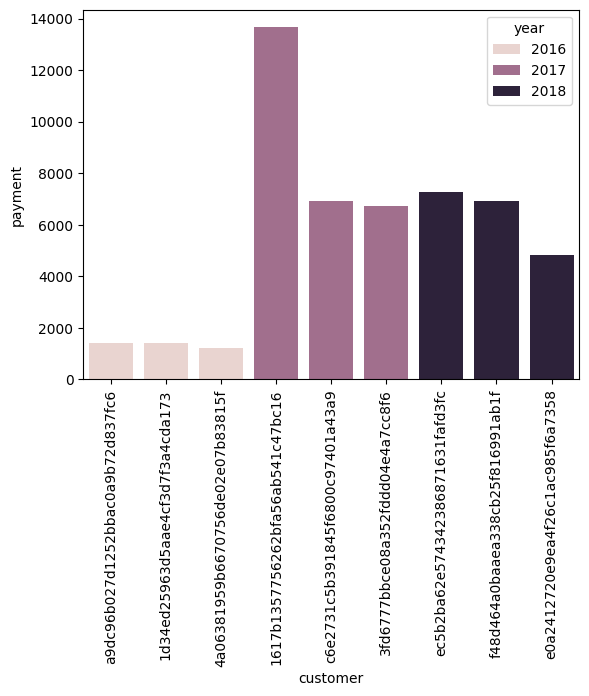

In [44]:
## Identify the top 3 customers who spent the most money in each year

q15 = """ 
SELECT year,customer,sales,d_rank
FROM
(SELECT YEAR(o.order_purchase_timestamp) as year,
o.customer_id as customer,
SUM(p.payment_value) as sales,
DENSE_RANK() OVER(PARTITION BY YEAR(o.order_purchase_timestamp) ORDER BY SUM(p.payment_value) DESC) AS d_rank
FROM orders o
JOIN payments p ON p.order_id = o.order_id
GROUP BY year,customer) as temp
where d_rank<4
"""

cur.execute(q15)
d15 = cur.fetchall()

df = pd.DataFrame(d15,columns=['year','customer','payment','rank'])
sns.barplot(x = "customer", y = "payment", data = df, hue = "year")
plt.xticks(rotation = 90)
plt.show()